In [1]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
project_dir='/data/projects/rf1-mbme-pilot'
subs=pd.read_csv('../derivatives/exclusions.csv')
print("We collected and downloaded data from %s subjects"%(len(subs['sub'].unique())))
GoodSubs=subs.groupby(by='sub').sum()
#print(GoodSubs.columns)
GoodSubs=GoodSubs[
    (GoodSubs['FD_exclusion']<=2)&(
        GoodSubs['ABS_exclusion']<=1)&(
        GoodSubs['Beh_TrialExclusion']<=2)].reset_index()
subs=subs[subs['sub'].isin(GoodSubs['sub'].values)].sort_values(by='sub')
subs.reset_index(inplace=True)

HC=[]
for index, row in subs.iterrows():
    if row['acq'] in ['mb1me4','mb3me4','mb6me4']:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_echo-1_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    else:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    #print(fname)
    f = open(fname)
    data = json.load(f)
    HC.append(data['ReceiveCoilName'])
    f.close()
subs['HeadCoil']=HC
subs['MB'] =  [int(re.search('mb(.*)me',str(x)).group(1)) for x in subs['acq']]
subs['ME'] =  [int(re.search('me(.*)',str(x)).group(1)) for x in subs['acq']]

print(" THere are %s number of subjects who passed the exclusion criteria."%(len(subs['sub'].unique())))
print(" %s Were collected using a 64 channel headcoil and %s with a 20 channel headcoil"%(len(subs[subs['HeadCoil']=='HeadNeck_64']['sub'].unique()),
                                                                                          len(subs[subs['HeadCoil']=='HeadNeck_20']['sub'].unique())))
  

We collected and downloaded data from 43 subjects
 THere are 32 number of subjects who passed the exclusion criteria.
 19 Were collected using a 64 channel headcoil and 13 with a 20 channel headcoil


# Count Subjects with full L1 output

In [3]:
act=[]
ppi=[]
for index,row in subs.iterrows():
    sub=row['sub']
    acq=row['acq']
    act.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))

subs['L1act']=act
subs['L1ppi']=ppi
#display(subs)
subs[subs['L1act']==False].head()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi
104,247,sub-10185,mb6me4,2,0.474361,0.077345,False,False,False,HeadNeck_20,6,4,False,False
131,47,sub-10223,mb6me1,0,0.307234,0.116129,False,False,False,HeadNeck_20,6,1,False,False
132,45,sub-10223,mb6me4,0,0.214031,0.118653,False,False,False,HeadNeck_20,6,4,False,False
133,44,sub-10223,mb3me1,0,0.539792,0.153557,False,False,False,HeadNeck_20,3,1,False,False
134,43,sub-10223,mb3me4,0,0.672768,0.124835,False,False,False,HeadNeck_20,3,4,False,False


VS


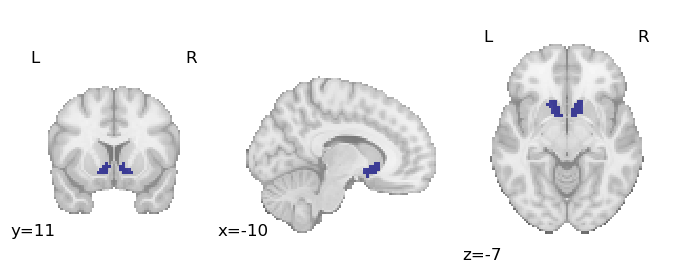

RVS


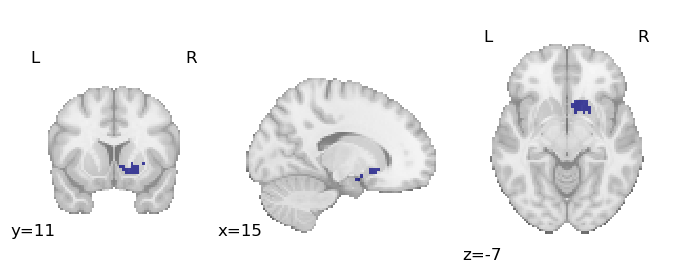

LVS


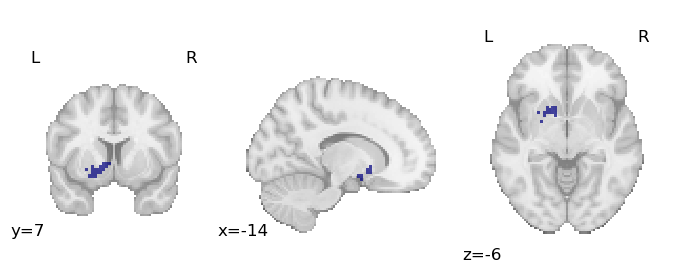

vmPFC


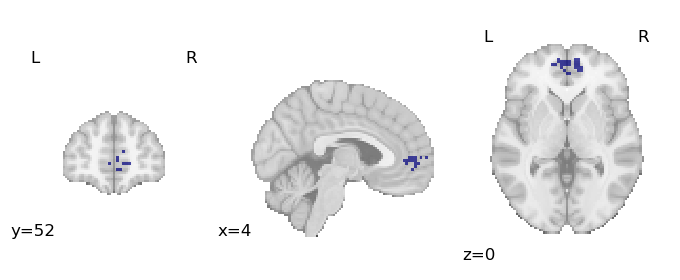

FFA


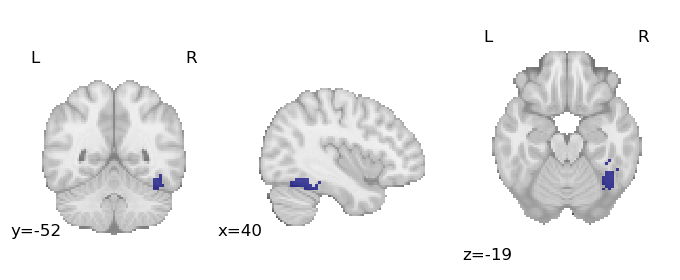

sCerb


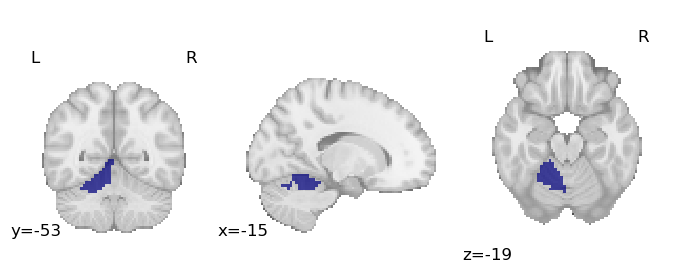

iCerb


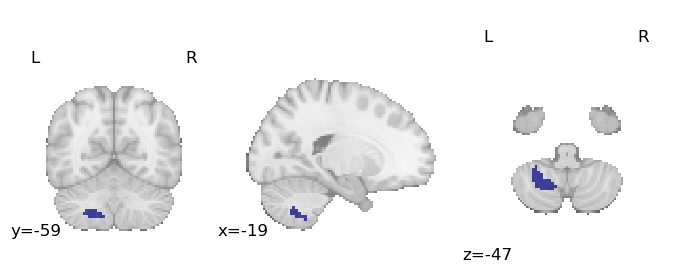

Motor


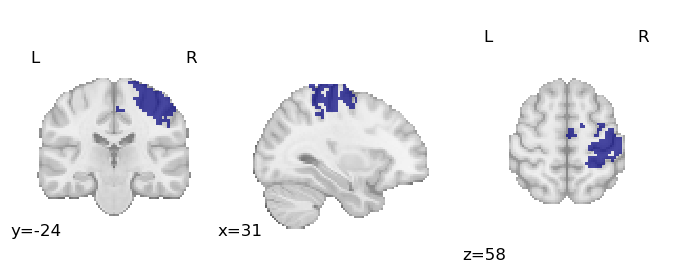

In [4]:
from nilearn import  image
#Striatum Mask
if 1==1:
    VS_mask='../masks/ROI-VS_cname-prereg.nii.gz'
    rstr_mask='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
    lstr_mask='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
    pfc_mask='../masks/fROI-vmPFC_cname-RewVsPun_zstat-1.nii.gz'
    FFA_mask='../masks/fROI-FFA_cname-StrVsComp_zstat-1.nii.gz'
    sCerb_mask='../masks/fROI-sCerb_cname-LeftVsRight_zstat-1.nii.gz'
    iCerb_mask='../masks/fROI-iCerb_cname-LeftVsRight_zstat-1.nii.gz'
    motor_mask='../masks/fROI-Motor_cname-LeftVsRight_zstat-1.nii.gz'
    mask_list=[VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]
    
    for mask in mask_list:
        str_mask=NiftiMasker(mask_img=mask)
        mask_name=re.search('ROI-(.*)_cname',mask).group(1)
        print(mask_name)
        plotting.plot_roi(mask,draw_cross=False)
        plt.savefig("../derivatives/figures/mask_%s.svg"%(mask_name))
        plt.show()

# VS- Reward Activiation

In [23]:
masker= NiftiMasker(mask_img=VS_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope13.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat13.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope13.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(VS_Reward_cope=copes,
               VS_Reward_zstats=zstats,
               VS_Reward_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [02:23<00:00,  1.32it/s]


# Display Reward Activation by Acquisition

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,...,VS_Reward_varcope,FFA_face_cope,FFA_face_zstats,FFA_face_varcope,Motor_LR_cope,Motor_LR_zstats,Motor_LR_varcope,pfc_con_cope,pfc_con_zstats,pfc_con_varcope
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,...,44009.523438,459.262634,2.114799,45739.433594,274.332794,1.649224,25791.662109,0.901813,1.779219,0.230941
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,...,67052.210938,404.881897,1.969945,39880.328125,251.233551,1.683806,20914.683594,0.250412,0.500446,0.206711
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,...,190647.031250,370.242249,1.104937,105355.742188,89.971230,0.375879,55665.023438,-0.053230,-0.072569,0.728807
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,...,63562.261719,534.048462,2.119892,66443.921875,270.878357,1.405144,36502.203125,0.798386,1.042088,0.568374
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,...,117382.937500,405.428223,1.556888,70155.945312,178.025192,0.972047,34224.453125,1.336376,1.069853,1.419567


Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: VS_Reward_zstats
No. Observations: 183     Method:             REML            
No. Groups:       31      Scale:              0.2063          
Min. group size:  5       Log-Likelihood:     -137.1202       
Max. group size:  6       Converged:          Yes             
Mean group size:  5.9                                         
----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------
Intercept   -0.047      0.130   -0.358   0.720   -0.302    0.209
MB           0.099      0.032    3.123   0.002    0.037    0.161
ME           0.081      0.043    1.899   0.058   -0.003    0.165
MB:ME       -0.023      0.011   -2.064   0.039   -0.044   -0.001
Group Var    0.041      0.048                                   
==============================================================

"""

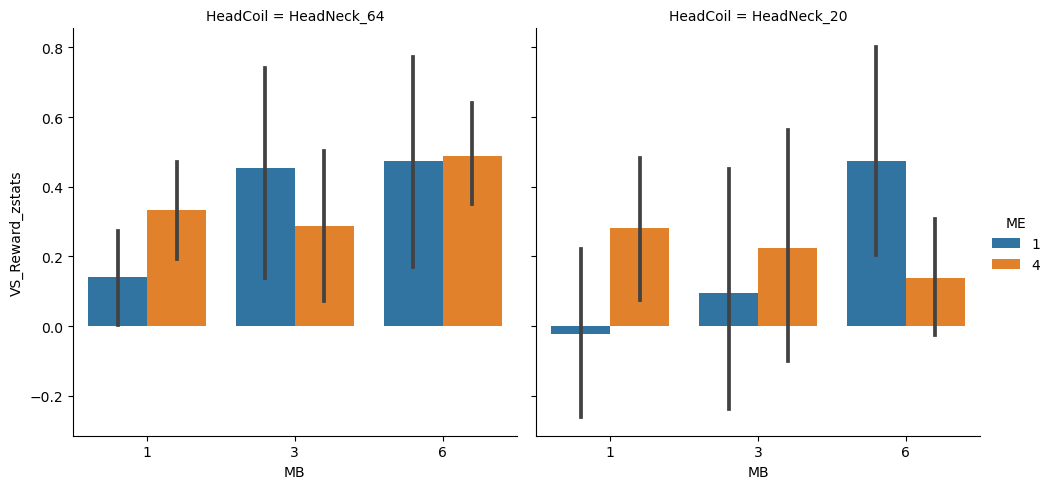

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: VS_Reward_cope
No. Observations: 183     Method:             REML          
No. Groups:       31      Scale:              18512.1295    
Min. group size:  5       Log-Likelihood:     -1159.2581    
Max. group size:  6       Converged:          Yes           
Mean group size:  5.9                                       
-------------------------------------------------------------
            Coef.    Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------
Intercept    -1.764    39.284  -0.045  0.964  -78.760  75.232
MB           19.406     9.512   2.040  0.041    0.763  38.050
ME           34.860    12.790   2.726  0.006    9.793  59.928
MB:ME        -7.042     3.267  -2.156  0.031  -13.444  -0.639
Group Var  4406.759    15.806                                
============================================================

"""

<Figure size 640x480 with 0 Axes>

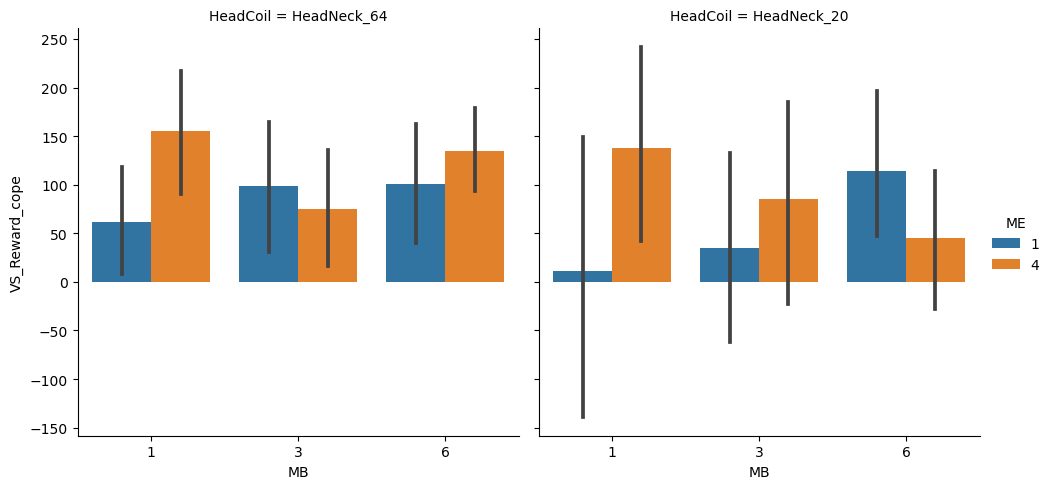

Results for VarCope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:              MixedLM   Dependent Variable:   VS_Reward_varcope
No. Observations:   183       Method:               REML             
No. Groups:         31        Scale:                4703631342.6759  
Min. group size:    5         Log-Likelihood:       -2284.6874       
Max. group size:    6         Converged:            Yes              
Mean group size:    5.9                                              
---------------------------------------------------------------------
              Coef.       Std.Err.   z    P>|z|   [0.025     0.975]  
---------------------------------------------------------------------
Intercept     229640.379 21549.938 10.656 0.000 187403.276 271877.481
MB            -37719.109  4796.272 -7.864 0.000 -47119.629 -28318.589
ME             -3918.218  6449.330 -0.608 0.543 -16558.672   8722.237
MB:ME           4783.339  1647.011  2.904 0.004   1555.257   8011.421
Group Var 3348421541.043 17044.038                                   
=====================================================================

"""

<Figure size 640x480 with 0 Axes>

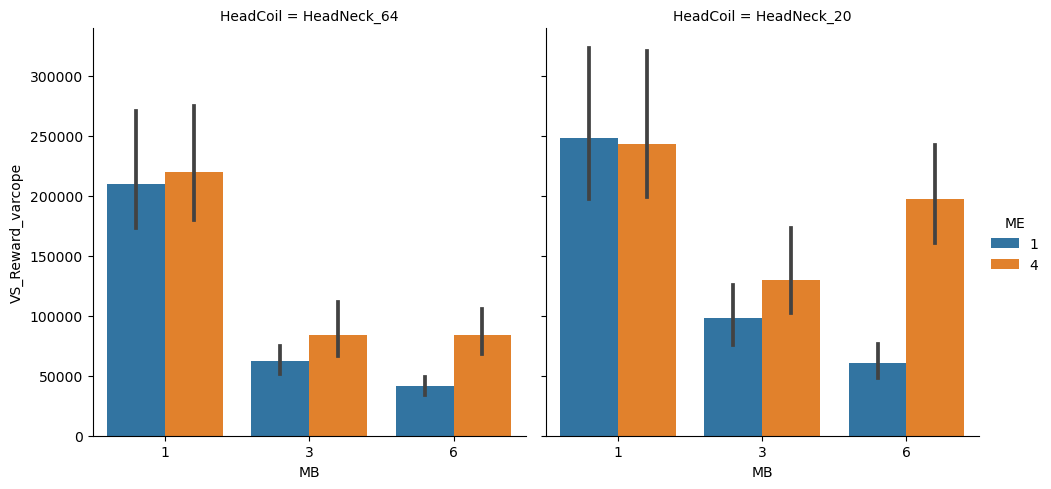

<Figure size 640x480 with 0 Axes>

In [24]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

display(subs.head())
print("Results for Zstatistics")
res=smf.mixedlm('VS_Reward_zstats ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='VS_Reward_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')
            
plt.show()
plt.savefig("../derivatives/figures/Reward_VS-act_zstat.svg")

print("Results for Cope") 
res=smf.mixedlm('VS_Reward_cope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='VS_Reward_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Reward_VS-act_cope.svg")


print("Results for VarCope")
res=smf.mixedlm('VS_Reward_varcope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='VS_Reward_varcope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Reward_VS-act_varcope.svg")


# FFA-Face Activiation

In [7]:
masker= NiftiMasker(mask_img=FFA_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope11.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope11.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(FFA_face_cope=copes,
               FFA_face_zstats=zstats,
               FFA_face_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [05:12<00:00,  1.65s/it]


# Display Face Activation by Acquisition (FFA)

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,VS_Reward_cope,VS_Reward_zstats,VS_Reward_varcope,FFA_face_cope,FFA_face_zstats,FFA_face_varcope
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,3,1,True,True,125.213081,0.556886,44009.523438,459.262634,2.114799,45739.433594
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,6,4,True,True,63.856640,0.225475,67052.210938,404.881897,1.969945,39880.328125
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,1,1,True,True,87.841202,0.216938,190647.031250,370.242249,1.104937,105355.742188
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,3,4,True,True,36.818584,0.177278,63562.261719,534.048462,2.119892,66443.921875
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,1,4,True,True,-28.379370,-0.068355,117382.937500,405.428223,1.556888,70155.945312


Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_face_zstats
No. Observations: 183     Method:             REML           
No. Groups:       31      Scale:              0.3997         
Min. group size:  5       Log-Likelihood:     -202.9134      
Max. group size:  6       Converged:          Yes            
Mean group size:  5.9                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.457     0.188   2.425  0.015   0.088   0.826
MB              0.029     0.044   0.666  0.506  -0.057   0.116
ME             -0.025     0.059  -0.418  0.676  -0.141   0.092
MB:ME           0.006     0.015   0.412  0.681  -0.024   0.036
Group Var       0.162     0.103                               
=============================================================

"""

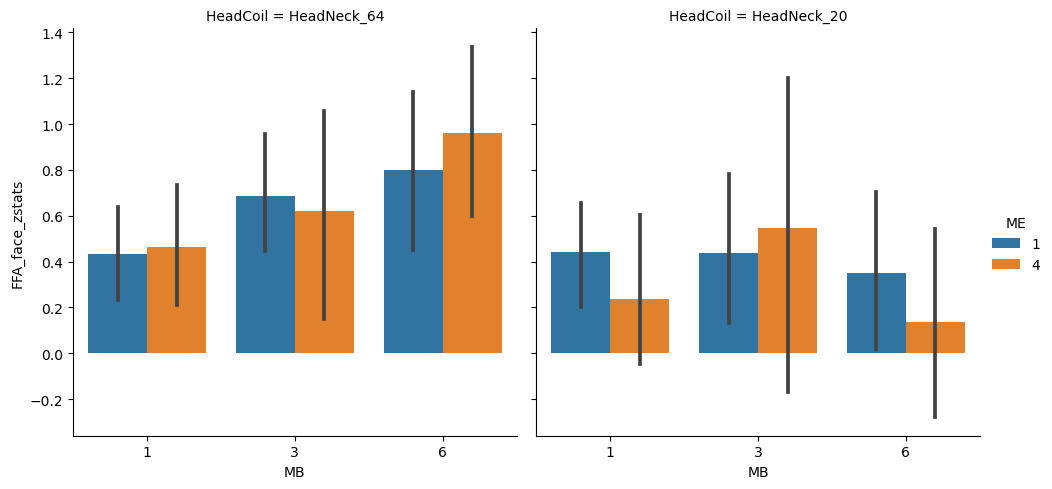

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_face_cope
No. Observations: 183     Method:             REML         
No. Groups:       31      Scale:              47415.6689   
Min. group size:  5       Log-Likelihood:     -1244.1677   
Max. group size:  6       Converged:          Yes          
Mean group size:  5.9                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     185.286   63.122  2.935 0.003  61.568 309.004
MB             -9.617   15.224 -0.632 0.528 -39.455  20.221
ME            -12.741   20.470 -0.622 0.534 -52.862  27.379
MB:ME           2.881    5.228  0.551 0.582  -7.365  13.128
Group Var   12254.748   26.272                             
===========================================================

"""

<Figure size 640x480 with 0 Axes>

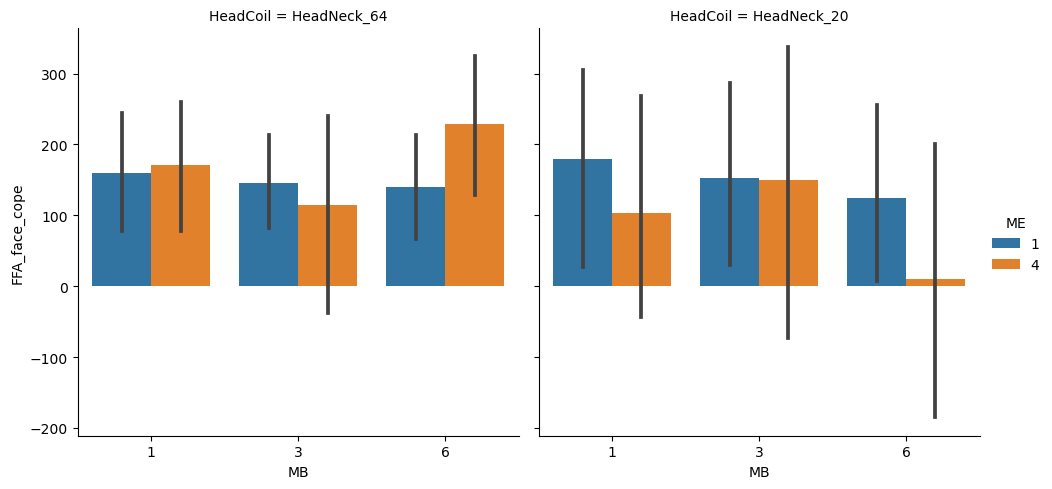

Results for VarCope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                MixedLM   Dependent Variable:   FFA_face_varcope
No. Observations:     183       Method:               REML            
No. Groups:           31        Scale:                20250059962.2055
Min. group size:      5         Log-Likelihood:       -2411.6352      
Max. group size:      6         Converged:            Yes             
Mean group size:      5.9                                             
----------------------------------------------------------------------
               Coef.       Std.Err.   z    P>|z|   [0.025     0.975]  
----------------------------------------------------------------------
Intercept      212711.702 43276.206  4.915 0.000 127891.897 297531.507
MB             -28958.525  9950.994 -2.910 0.004 -48462.115  -9454.935
ME               9980.096 13380.500  0.746 0.456 -16245.203  36205.395
MB:ME            1486.596  3417.138  0.435 0.664  -5210.872   8184.064
Group Var 10506707873.260 27633.724                                   
======================================================================

"""

<Figure size 640x480 with 0 Axes>

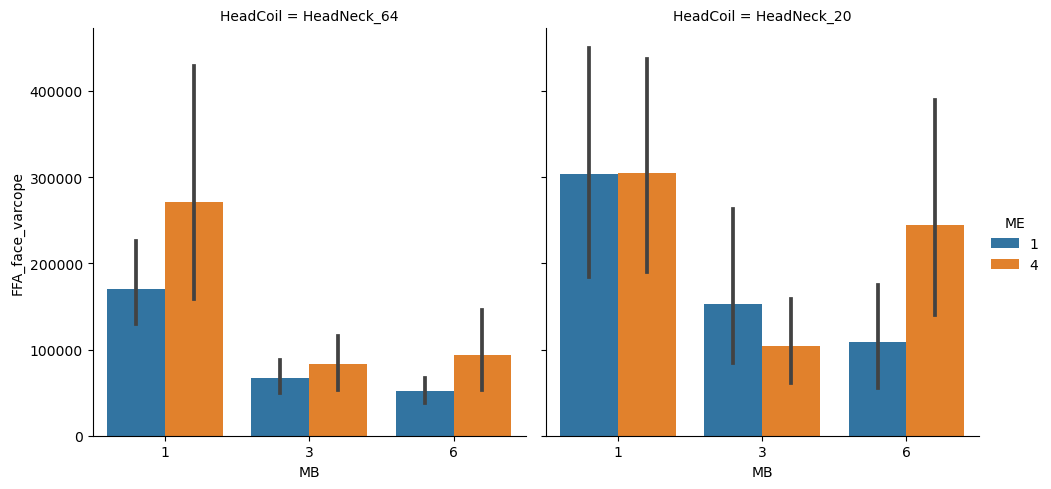

<Figure size 640x480 with 0 Axes>

In [8]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

display(subs.head())
print("Results for Zstatistics")
res=smf.mixedlm('FFA_face_zstats ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_zstats',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Face_FFA-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('FFA_face_cope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Face_FFA-act_cope.svg")


print("Results for VarCope")
res=smf.mixedlm('FFA_face_varcope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_varcope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Face_FFA-act_varcope.svg")


# Central Gyrus-Button Activiation

In [9]:
masker= NiftiMasker(mask_img=motor_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(Motor_LR_cope=copes,
               Motor_LR_zstats=zstats,
               Motor_LR_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [02:35<00:00,  1.22it/s]


# Display Motor Activation by Acquisition

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,...,L1ppi,VS_Reward_cope,VS_Reward_zstats,VS_Reward_varcope,FFA_face_cope,FFA_face_zstats,FFA_face_varcope,Motor_LR_cope,Motor_LR_zstats,Motor_LR_varcope
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,...,True,125.213081,0.556886,44009.523438,459.262634,2.114799,45739.433594,274.332794,1.649224,25791.662109
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,...,True,63.856640,0.225475,67052.210938,404.881897,1.969945,39880.328125,251.233551,1.683806,20914.683594
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,...,True,87.841202,0.216938,190647.031250,370.242249,1.104937,105355.742188,89.971230,0.375879,55665.023438
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,...,True,36.818584,0.177278,63562.261719,534.048462,2.119892,66443.921875,270.878357,1.405144,36502.203125
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,...,True,-28.379370,-0.068355,117382.937500,405.428223,1.556888,70155.945312,178.025192,0.972047,34224.453125


Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 183     Method:             REML           
No. Groups:       31      Scale:              0.3246         
Min. group size:  5       Log-Likelihood:     -191.5747      
Max. group size:  6       Converged:          Yes            
Mean group size:  5.9                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.440     0.181   2.434  0.015   0.086   0.794
MB              0.170     0.040   4.277  0.000   0.092   0.249
ME              0.070     0.054   1.309  0.191  -0.035   0.175
MB:ME          -0.028     0.014  -2.049  0.041  -0.055  -0.001
Group Var       0.249     0.151                               
=============================================================

"""

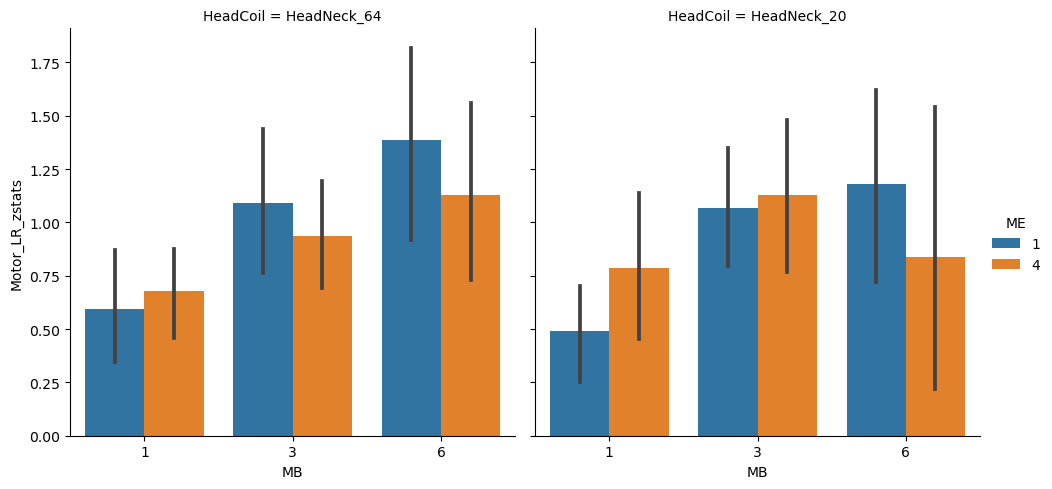

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 183     Method:             REML         
No. Groups:       31      Scale:              32508.1200   
Min. group size:  5       Log-Likelihood:     -1216.7108   
Max. group size:  6       Converged:          Yes          
Mean group size:  5.9                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     182.583   54.491  3.351 0.001  75.782 289.384
MB             13.952   12.609  1.107 0.269 -10.761  38.665
ME             26.539   16.955  1.565 0.118  -6.692  59.771
MB:ME          -6.427    4.330 -1.484 0.138 -14.914   2.060
Group Var   15704.863   33.530                             
===========================================================

"""

<Figure size 640x480 with 0 Axes>

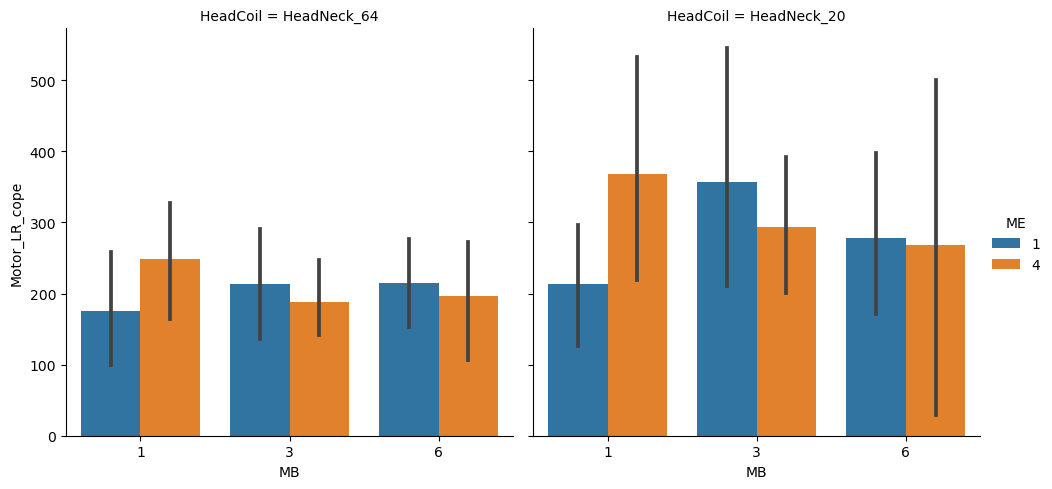

Results for VarCope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   Motor_LR_varcope
No. Observations:    183       Method:               REML            
No. Groups:          31        Scale:                9402772621.8733 
Min. group size:     5         Log-Likelihood:       -2346.0313      
Max. group size:     6         Converged:            Yes             
Mean group size:     5.9                                             
---------------------------------------------------------------------
              Coef.       Std.Err.   z    P>|z|   [0.025     0.975]  
---------------------------------------------------------------------
Intercept     152831.447 30281.808  5.047 0.000  93480.194 212182.701
MB            -20629.470  6781.303 -3.042 0.002 -33920.579  -7338.361
ME             12028.273  9118.568  1.319 0.187  -5843.791  29900.337
MB:ME           -769.009  2328.758 -0.330 0.741  -5333.290   3795.272
Group Var 6342038827.016 23168.143                                   
=====================================================================

"""

<Figure size 640x480 with 0 Axes>

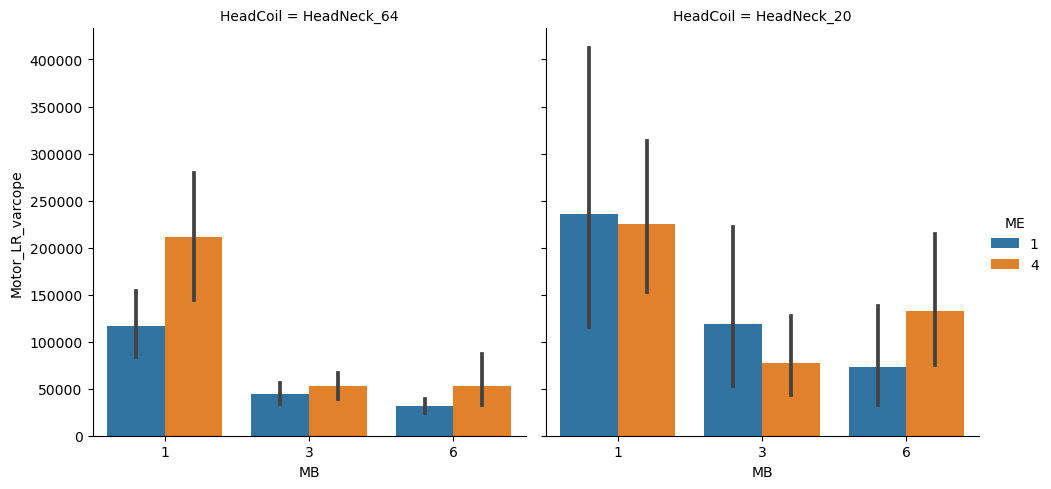

<Figure size 640x480 with 0 Axes>

In [10]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

display(subs.head())
print("Results for Zstatistics")
res=smf.mixedlm('Motor_LR_zstats ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_zstats',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('Motor_LR_cope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_cope.svg")


print("Results for VarCope")
res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_varcope.svg")


# Central Gyrus-Button Activiation

# Central ICerbt-Button Activiation

In [25]:
masker= NiftiMasker(mask_img=iCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(iCerb_LR_cope=copes,
               iCerb_LR_zstats=zstats,
               iCerb_LR_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [03:16<00:00,  1.03s/it]


# Display Motor Activation by Acquisition

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,...,VS_Reward_varcope,FFA_face_cope,FFA_face_zstats,FFA_face_varcope,Motor_LR_cope,Motor_LR_zstats,Motor_LR_varcope,pfc_con_cope,pfc_con_zstats,pfc_con_varcope
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,...,44009.523438,459.262634,2.114799,45739.433594,228.036774,1.009777,50210.058594,0.901813,1.779219,0.230941
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,...,67052.210938,404.881897,1.969945,39880.328125,250.037155,1.230819,38449.359375,0.250412,0.500446,0.206711
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,...,190647.031250,370.242249,1.104937,105355.742188,-75.004967,-0.237614,117189.703125,-0.053230,-0.072569,0.728807
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,...,63562.261719,534.048462,2.119892,66443.921875,269.551208,0.960145,79679.578125,0.798386,1.042088,0.568374
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,...,117382.937500,405.428223,1.556888,70155.945312,-2.543294,-0.036457,78961.656250,1.336376,1.069853,1.419567


Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 183     Method:             REML           
No. Groups:       31      Scale:              0.2566         
Min. group size:  5       Log-Likelihood:     -162.5267      
Max. group size:  6       Converged:          Yes            
Mean group size:  5.9                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.030     0.150  -0.200  0.841  -0.325   0.264
MB              0.139     0.035   3.912  0.000   0.069   0.208
ME              0.097     0.048   2.046  0.041   0.004   0.191
MB:ME          -0.024     0.012  -1.933  0.053  -0.047   0.000
Group Var       0.097     0.078                               
=============================================================

"""

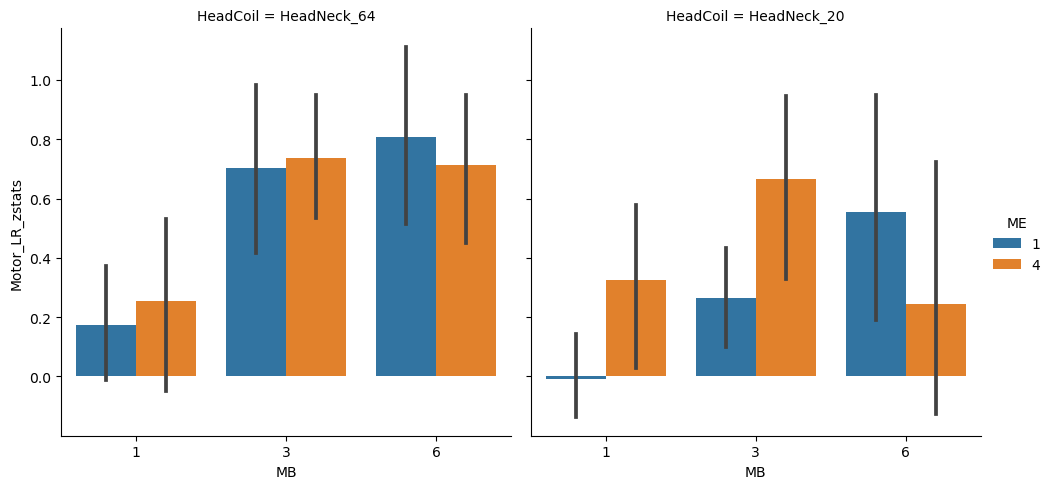

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 183     Method:             REML         
No. Groups:       31      Scale:              36706.3310   
Min. group size:  5       Log-Likelihood:     -1221.9291   
Max. group size:  6       Converged:          Yes          
Mean group size:  5.9                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept      30.502   55.750  0.547 0.584 -78.765 139.770
MB             23.043   13.395  1.720 0.085  -3.211  49.297
ME             24.471   18.011  1.359 0.174 -10.831  59.772
MB:ME          -4.211    4.600 -0.915 0.360 -13.226   4.804
Group Var   10208.954   24.175                             
===========================================================

"""

<Figure size 640x480 with 0 Axes>

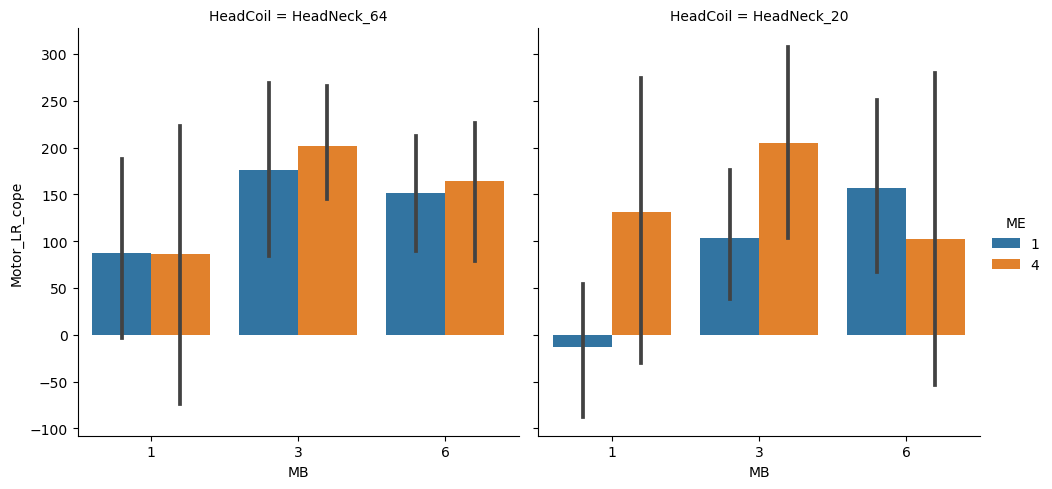

Results for VarCope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   Motor_LR_varcope
No. Observations:    183       Method:               REML            
No. Groups:          31        Scale:                19495290873.4244
Min. group size:     5         Log-Likelihood:       -2399.3704      
Max. group size:     6         Converged:            Yes             
Mean group size:     5.9                                             
---------------------------------------------------------------------
              Coef.       Std.Err.   z    P>|z|   [0.025     0.975]  
---------------------------------------------------------------------
Intercept     232740.094 40105.208  5.803 0.000 154135.332 311344.856
MB            -31235.174  9761.373 -3.200 0.001 -50367.113 -12103.235
ME             -1463.889 13125.253 -0.112 0.911 -27188.912  24261.134
MB:ME           3414.423  3352.632  1.018 0.308  -3156.616   9985.461
Group Var 4124485045.525 15292.478                                   
=====================================================================

"""

<Figure size 640x480 with 0 Axes>

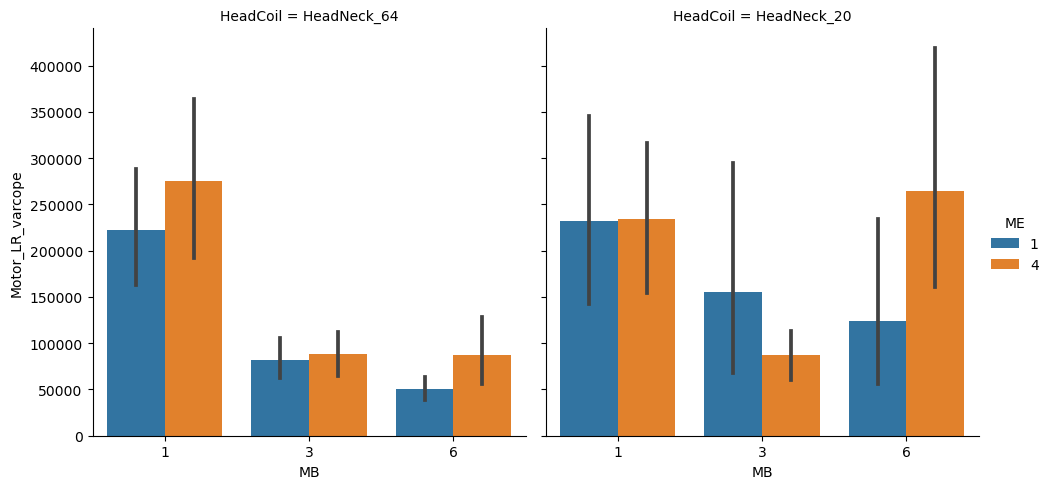

<Figure size 640x480 with 0 Axes>

In [26]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

display(subs.head())
print("Results for Zstatistics")
res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_zstats',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.savefig("../derivatives/figures/iCerb_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('Motor_LR_cope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.savefig("../derivatives/figures/iCerb_LR-act_cope.svg")
plt.show()



print("Results for VarCope")
res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_varcope.svg")


# SCerb-Button Activiation

In [27]:
masker= NiftiMasker(mask_img=sCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(Motor_LR_cope=copes,
               Motor_LR_zstats=zstats,
               Motor_LR_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [03:03<00:00,  1.03it/s]


# Display Motor Activation by Acquisition

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,...,VS_Reward_varcope,FFA_face_cope,FFA_face_zstats,FFA_face_varcope,Motor_LR_cope,Motor_LR_zstats,Motor_LR_varcope,pfc_con_cope,pfc_con_zstats,pfc_con_varcope
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,...,44009.523438,459.262634,2.114799,45739.433594,252.286041,1.072261,67933.500000,0.901813,1.779219,0.230941
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,...,67052.210938,404.881897,1.969945,39880.328125,219.921143,1.018373,55083.703125,0.250412,0.500446,0.206711
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,...,190647.031250,370.242249,1.104937,105355.742188,129.355682,0.356292,159664.359375,-0.053230,-0.072569,0.728807
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,...,63562.261719,534.048462,2.119892,66443.921875,290.883667,0.978639,104736.601562,0.798386,1.042088,0.568374
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,...,117382.937500,405.428223,1.556888,70155.945312,122.708923,0.378625,110892.796875,1.336376,1.069853,1.419567


Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 183     Method:             REML           
No. Groups:       31      Scale:              0.2369         
Min. group size:  5       Log-Likelihood:     -157.9659      
Max. group size:  6       Converged:          Yes            
Mean group size:  5.9                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.182     0.147   1.240  0.215  -0.106   0.471
MB              0.133     0.034   3.896  0.000   0.066   0.199
ME              0.071     0.046   1.560  0.119  -0.018   0.161
MB:ME          -0.021     0.012  -1.835  0.067  -0.044   0.001
Group Var       0.114     0.089                               
=============================================================

"""

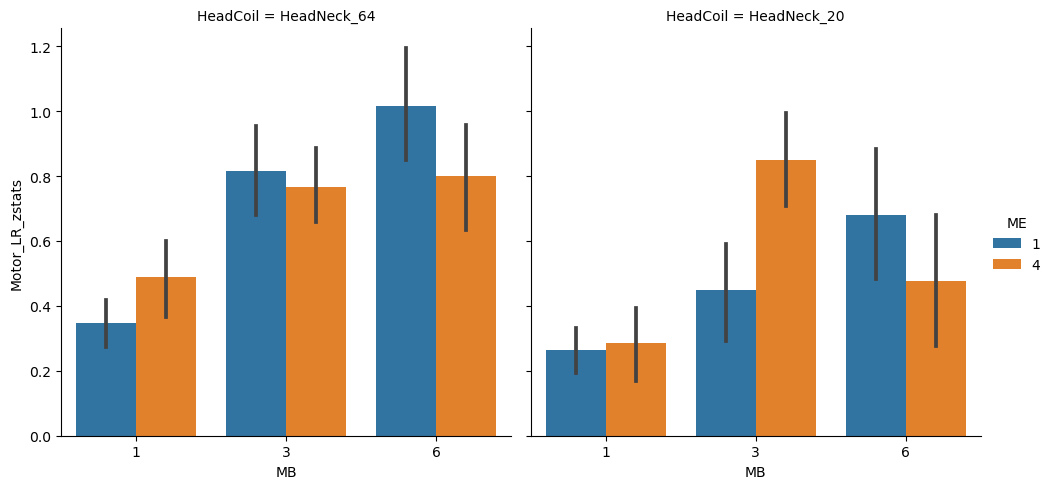

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 183     Method:             REML         
No. Groups:       31      Scale:              39908.6437   
Min. group size:  5       Log-Likelihood:     -1229.8235   
Max. group size:  6       Converged:          Yes          
Mean group size:  5.9                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     166.453   58.269  2.857 0.004  52.249 280.658
MB              6.590   13.967  0.472 0.637 -20.785  33.965
ME              7.487   18.780  0.399 0.690 -29.321  44.296
MB:ME          -1.117    4.796 -0.233 0.816 -10.517   8.283
Group Var   11592.817   25.860                             
===========================================================

"""

<Figure size 640x480 with 0 Axes>

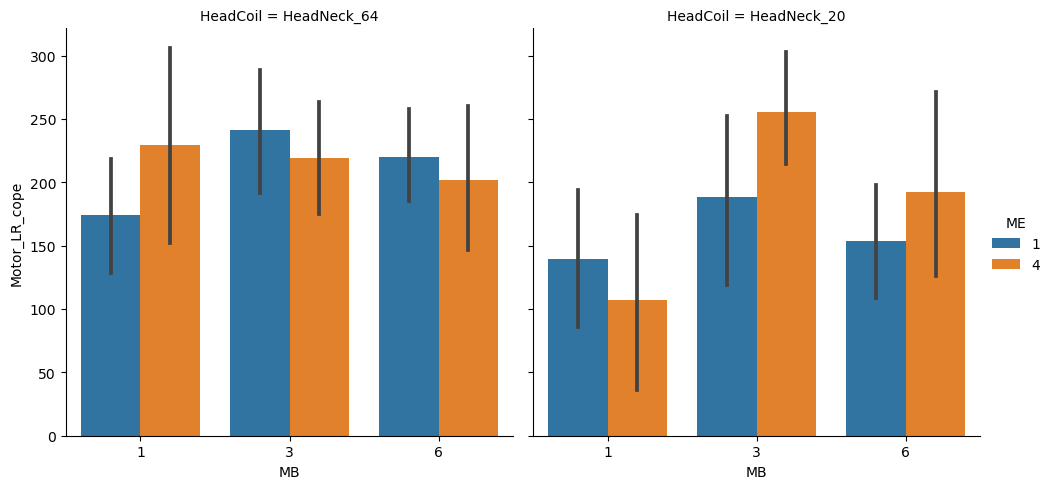

Results for VarCope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                MixedLM   Dependent Variable:   Motor_LR_varcope
No. Observations:     183       Method:               REML            
No. Groups:           31        Scale:                45325645313.6770
Min. group size:      5         Log-Likelihood:       -2488.7294      
Max. group size:      6         Converged:            Yes             
Mean group size:      5.9                                             
----------------------------------------------------------------------
               Coef.       Std.Err.   z    P>|z|   [0.025     0.975]  
----------------------------------------------------------------------
Intercept      384621.613 67748.592  5.677 0.000 251836.813 517406.414
MB             -58746.915 14889.118 -3.946 0.000 -87929.050 -29564.779
ME               6482.226 20020.803  0.324 0.746 -32757.827  45722.279
MB:ME            5148.987  5112.941  1.007 0.314  -4872.193  15170.167
Group Var 35816077258.321 57791.433                                   
======================================================================

"""

<Figure size 640x480 with 0 Axes>

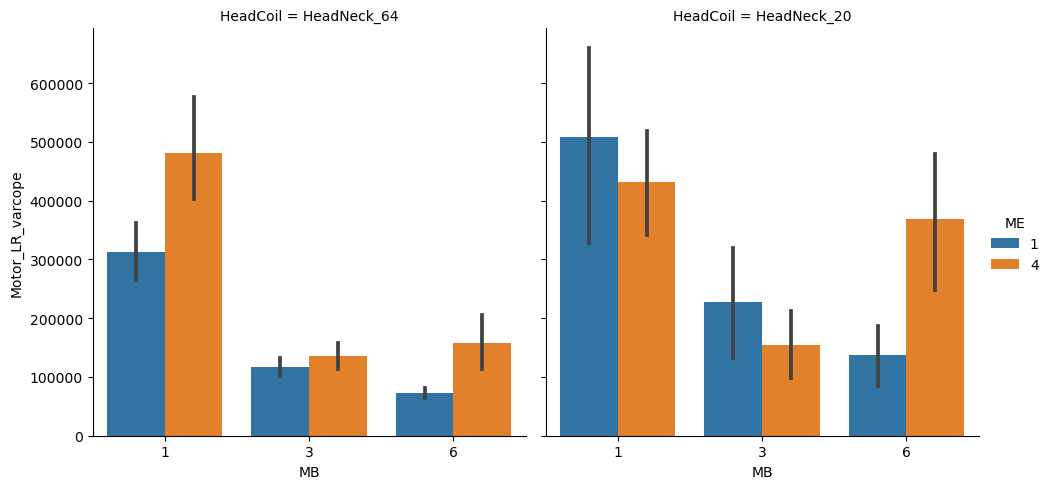

<Figure size 640x480 with 0 Axes>

In [28]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

display(subs.head())
print("Results for Zstatistics")
res=smf.mixedlm('Motor_LR_zstats ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_zstats',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6],ci=68)
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('Motor_LR_cope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6],ci=68)
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_cope.svg")


print("Results for VarCope")
res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6],ci=68)
plt.show()
plt.savefig("../derivatives/figures/Motor_LR-act_varcope.svg")


# VS-vmPFC Connectivity

In [15]:
masker= NiftiMasker(mask_img=pfc_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/cope17.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/tstat17.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/varcope17.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(pfc_con_cope=copes,
               pfc_con_zstats=zstats,
               pfc_con_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [02:17<00:00,  1.38it/s]


# Display Connectivity (VS-vmpFC) by Acquisition

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,...,VS_Reward_varcope,FFA_face_cope,FFA_face_zstats,FFA_face_varcope,Motor_LR_cope,Motor_LR_zstats,Motor_LR_varcope,pfc_con_cope,pfc_con_zstats,pfc_con_varcope
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,...,44009.523438,459.262634,2.114799,45739.433594,274.332794,1.649224,25791.662109,0.901813,1.779219,0.230941
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,...,67052.210938,404.881897,1.969945,39880.328125,251.233551,1.683806,20914.683594,0.250412,0.500446,0.206711
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,...,190647.031250,370.242249,1.104937,105355.742188,89.971230,0.375879,55665.023438,-0.053230,-0.072569,0.728807
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,...,63562.261719,534.048462,2.119892,66443.921875,270.878357,1.405144,36502.203125,0.798386,1.042088,0.568374
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,...,117382.937500,405.428223,1.556888,70155.945312,178.025192,0.972047,34224.453125,1.336376,1.069853,1.419567


Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: pfc_con_zstats
No. Observations: 183     Method:             REML          
No. Groups:       31      Scale:              0.2989        
Min. group size:  5       Log-Likelihood:     -172.8739     
Max. group size:  6       Converged:          Yes           
Mean group size:  5.9                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.399     0.159   2.511  0.012   0.088   0.710
MB             0.065     0.038   1.699  0.089  -0.010   0.140
ME             0.063     0.051   1.224  0.221  -0.038   0.164
MB:ME         -0.016     0.013  -1.238  0.216  -0.042   0.009
Group Var      0.081     0.068                               
============================================================

"""

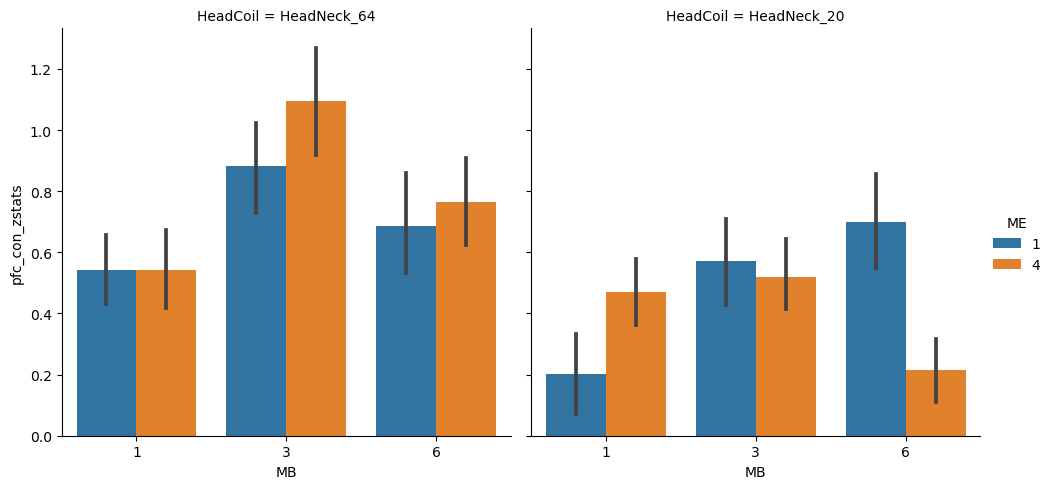

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: pfc_con_cope
No. Observations: 183     Method:             REML        
No. Groups:       31      Scale:              0.2136      
Min. group size:  5       Log-Likelihood:     -130.2777   
Max. group size:  6       Converged:          No          
Mean group size:  5.9                                     
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    0.317     0.128   2.483  0.013   0.067   0.567
MB           0.006     0.032   0.191  0.848  -0.057   0.069
ME           0.160     0.043   3.690  0.000   0.075   0.245
MB:ME       -0.031     0.011  -2.805  0.005  -0.053  -0.009
Group Var    0.005     0.019                               
==========================================================

"""

<Figure size 640x480 with 0 Axes>

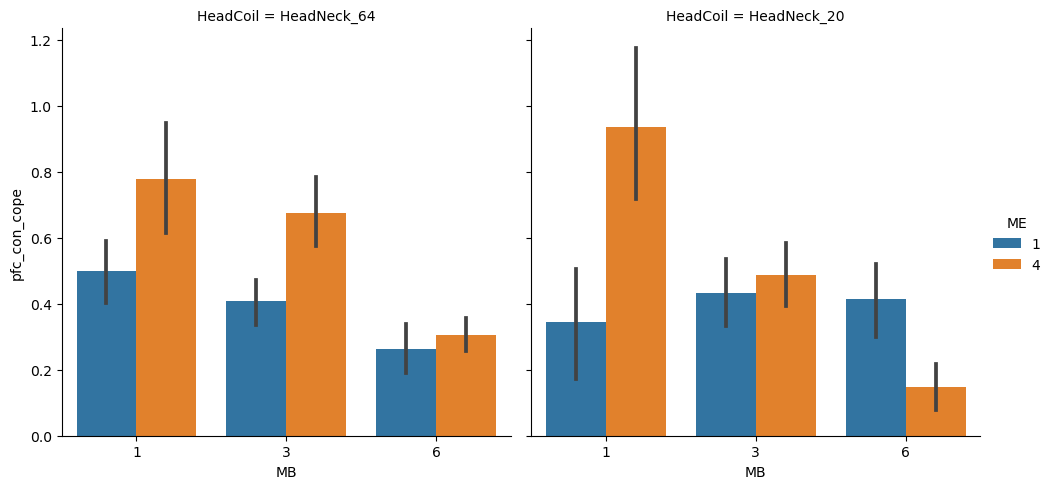

Results for VarCope


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: pfc_con_varcope
No. Observations: 183     Method:             REML           
No. Groups:       31      Scale:              2.2163         
Min. group size:  5       Log-Likelihood:     -351.1762      
Max. group size:  6       Converged:          Yes            
Mean group size:  5.9                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.864     0.430   2.009  0.045   0.021   1.707
MB             -0.106     0.104  -1.014  0.310  -0.310   0.098
ME              0.620     0.140   4.432  0.000   0.346   0.894
MB:ME          -0.117     0.036  -3.269  0.001  -0.187  -0.047
Group Var       0.536     0.172                               
=============================================================

"""

<Figure size 640x480 with 0 Axes>

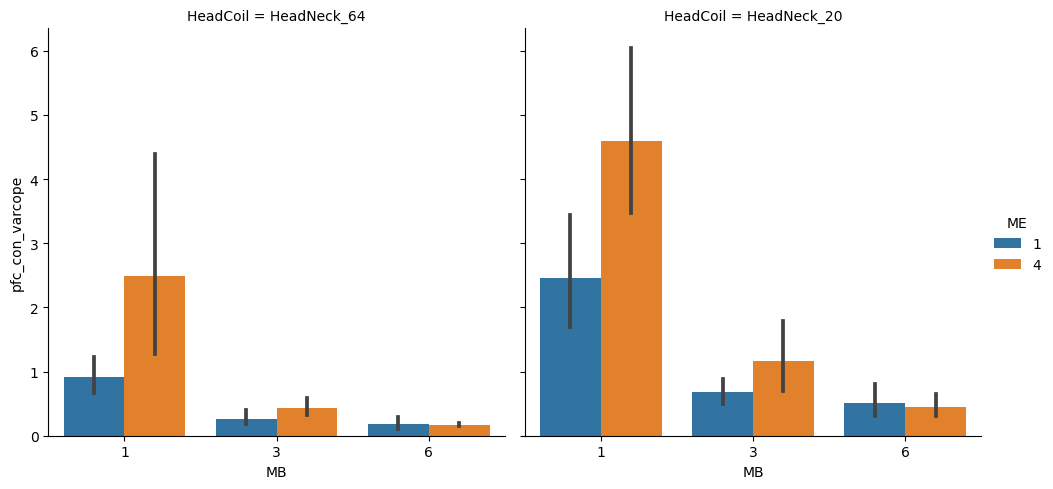

<Figure size 640x480 with 0 Axes>

In [16]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

display(subs.head())
print("Results for Zstatistics")
res=smf.mixedlm('pfc_con_zstats ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_con_zstats',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6],ci=68)
plt.show()
plt.savefig("../derivatives/figures/pfc_con-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('pfc_con_cope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_con_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6],ci=68)
plt.show()
plt.savefig("../derivatives/figures/pfc_con-act_cope.svg")


print("Results for VarCope")
res=smf.mixedlm('pfc_con_varcope ~ MB * ME * HC',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_con_varcope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/pfc_con-act_varcope.svg",ci=68)
